In [57]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')
import pandas as pd
from scipy.stats import zscore, norm
import matplotlib.pyplot as plt


<Figure size 1500x1000 with 0 Axes>

In [87]:
pca_per_pathway = pd.read_csv('../data/pca_per_pathway.csv', index_col=0)

new_clinical_patient = pd.read_csv('../data/data_clinical_patient.txt', sep='\t', index_col=0).iloc[4:]
new_clinical_sample = pd.read_csv('../data/data_clinical_sample.txt', sep='\t', index_col=0).iloc[4:]
new_clinical = pd.concat([new_clinical_patient, new_clinical_sample.reindex(new_clinical_patient.index)], axis=1)
new_clinical['Triple Neg'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Negative')) else False, axis = 1)

new_clinical['ER-/PR-/HER2+'] = new_clinical.apply(lambda row: True if ((row['ER Status'] == 'Negative') 
                                                                     and (row['PR Status'] == 'Negative') 
                                                                     and (row['HER2 Status'] == 'Positive')) else False, axis = 1)


full_df = pd.concat([pca_per_pathway, new_clinical.reindex(pca_per_pathway.index)], axis=1)

In [152]:
from scipy.stats import ttest_ind, mannwhitneyu
import qvalue as qv

clusterframes = {}

grouped_by_cluster = full_df.groupby('Integrative Cluster')

for group in grouped_by_cluster:
    df_cluster = pd.DataFrame(index=full_df.iloc[:,:-33].columns)
    groupname = group[0]
    df = group[1].iloc[:,:-33]
    group2_df = full_df[full_df['Integrative Cluster'] != groupname].iloc[:,:-33]
    pvaluelist = []
    group1_mean_list = []
    group2_mean_list = []
    for pathway in df:
        group = df[pathway]
        group2 = group2_df[pathway]
        test = mannwhitneyu(group, group2, alternative='two-sided')
        pvaluelist.append(test[1])
        group_mean = group.mean()
        group1_mean_list.append(group_mean)
        group2_mean = group2.mean()
        group2_mean_list.append(group2_mean) 
        
    
    df_cluster[f'Cluster {groupname}'] = group1_mean_list
    df_cluster['Other clusters'] = group2_mean_list
    df_cluster['Fold Change'] = np.log2(abs(df_cluster[f'Cluster {groupname}'])) - np.log2(abs(df_cluster['Other clusters']))
    
    
    df_cluster['p-values'] = pvaluelist
    qv.qvalues(df_cluster, 'p-values', f'cluster {groupname} qvalues')
    #df_cluster['p-values'] = -np.log10(df_cluster['p-values'])
    #df_cluster[f'cluster {groupname} qvalues'] = -np.log10(df_cluster[f'cluster {groupname} qvalues'])
    print(groupname)
    clusterframes[groupname] = df_cluster
        
        

1
10
2
3
4ER+
4ER-
5
6
7
8
9


In [151]:
from statistics import mean, median
listofnums = clusterframes['1']['p-values'].tolist()
print(type(listofnums[0]))
print(mean(listofnums))
print(median(listofnums))

<class 'float'>
0.09231541492048106
0.005000226400064709


[-6.57759601 -6.47590464 -6.45937559 ...  2.84108948  3.34172735
  3.76504722]


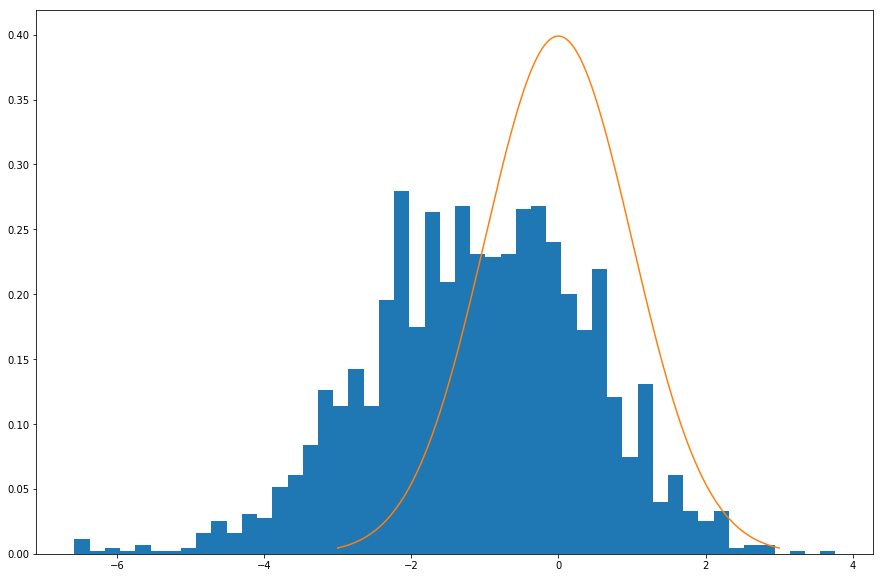

In [167]:
from scipy.stats import norm
def null_testing_cluster(cluster):
    ##Generate Zscores
    #series = zscore(clusterframes[cluster][f'cluster {cluster} qvalues'])
    p_vals= clusterframes[cluster][f'p-values'].tolist()
    p_significance = norm.ppf(p_vals)
    print(p_significance)
    
    ## Plot distribution of pathway eigenvalues
    plt.figure(figsize=(15, 10))
    plt.hist(p_significance, bins=50, density=True)

    ##Null distribution
    x = np.linspace(mu -3*sigma, mu+ 3*sigma, 1000)
    plt.plot(x, norm.pdf(x, 0, 1))
    plt.savefig(f'cluster_{cluster}_p_distribution.png')
    plt.show()
    
null_testing_cluster('2')


[-11.79939041 -11.56722125 -11.40078742 ...   2.69326869   3.13682335
   3.66849305]


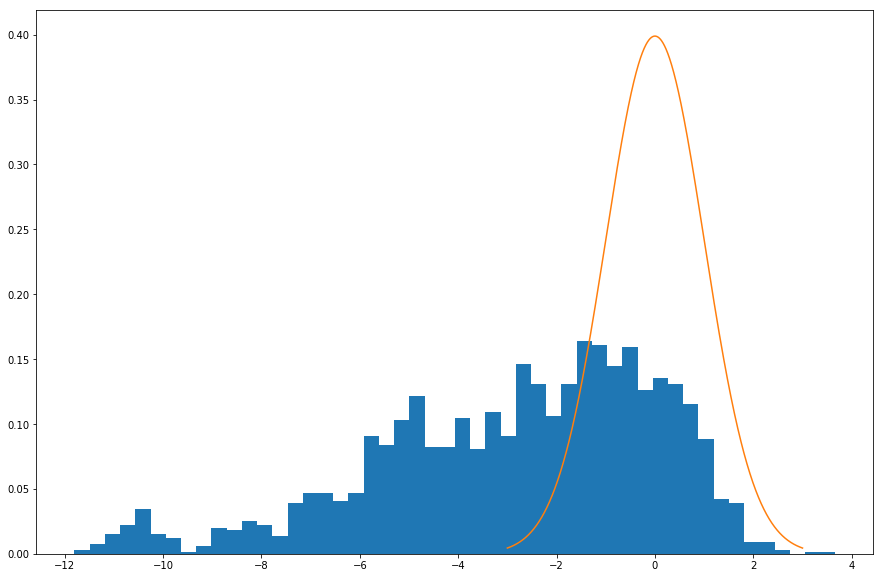

In [179]:
null_testing_cluster('1')

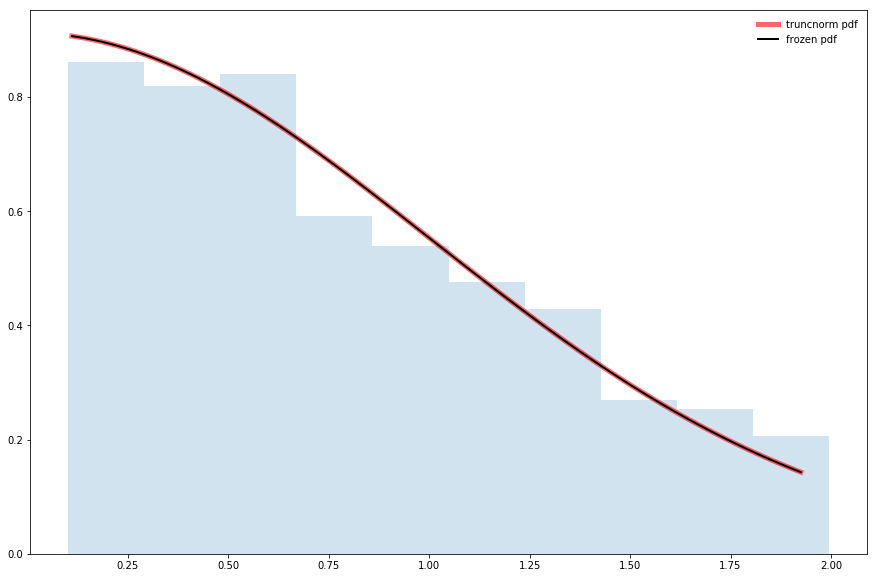

In [192]:
from scipy.stats import truncnorm
fig, ax = plt.subplots(1, 1, figsize=(15,10))
a, b = 0.1, 2
mean, var, skew, kurt = truncnorm.stats(a, b, moments='mvsk')
x=np.linspace(truncnorm.ppf(0.01, a, b), truncnorm.ppf(0.99, a, b), 100)
ax.plot(x, truncnorm.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label = 'truncnorm pdf')

rv = truncnorm(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = truncnorm.ppf([0.001, 0.5, 0.999], a, b)
np.allclose([0.001, 0.5, 0.999], truncnorm.cdf(vals, a, b))

r= truncnorm.rvs(a, b, size=1000)
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

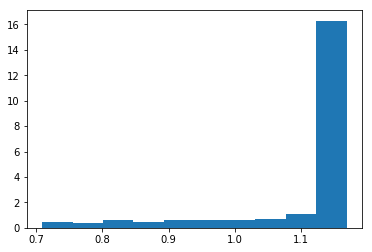

In [197]:
def make_pdf(cluster):
    p_vals = clusterframes[cluster][f'p-values'].tolist()
    a, b = 0, 1
    pdf_ = truncnorm.pdf(p_vals, a, b)
    plt.hist(pdf_, density=True)
    plt.show()
    
make_pdf('1')

In [131]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
results = ols("Q('Interleukin-7 signaling') ~ C(Q('Integrative Cluster'))", data=full_df).fit()
table = sm.stats.anova_lm(results, typ=2)
print(table)
print(dir(table))
print(table.F)
print(type(table))

                                  sum_sq      df          F        PR(>F)
C(Q('Integrative Cluster'))  1440.973130    10.0  33.259333  3.272314e-60
Residual                     8530.766768  1969.0        NaN           NaN
['F', 'T', '_AXIS_ALIASES', '_AXIS_IALIASES', '_AXIS_LEN', '_AXIS_NAMES', '_AXIS_NUMBERS', '_AXIS_ORDERS', '_AXIS_REVERSED', '__abs__', '__add__', '__and__', '__annotations__', '__array__', '__array_priority__', '__array_wrap__', '__bool__', '__class__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__div__', '__doc__', '__eq__', '__finalize__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lt__', '__matmul__', '__mod__', '__modu